# ROBUST MULTICLASS CLASSIFIER

In [1]:
import numpy
import pandas
import tensorflow
import keras
from matplotlib import pyplot
import seaborn
import itertools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K

%matplotlib inline

## INPUT PARAMETERS HERE

In [2]:
# COOK PARAMETERS
file_name = 'iris.data'
class_col = 'flower'
my_metric = 'Accuracy'
relevant_features = 2
my_patience = 50
min_improvement = 0.01
min_neuron_gain = 0.025
random_seed = 33
n_k_folds = 3
learning_rate = 0.01
hidden_activations = ['tanh', 'relu'] # 'tanh' 'relu' 'sigmoid' 'softmax' 'softplus' 'softsign' 'selu' 'elu' 'exponential' 'linear'
rollback_on_no_lower_bound_gain = True
my_optimizers = ['adam', 'adagrad', 'rmsprop']

# my_optimizers = {'adagrad': tensorflow.keras.optimizers.Adagrad(learning_rate=learning_rate),
#                  'rmsprop': tensorflow.keras.optimizers.RMSprop(learning_rate=learning_rate),
#                  'adam': tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)}

## CHECK TENSORFLOW GPU

In [3]:
tensorflow.config.list_physical_devices('GPU')

[]

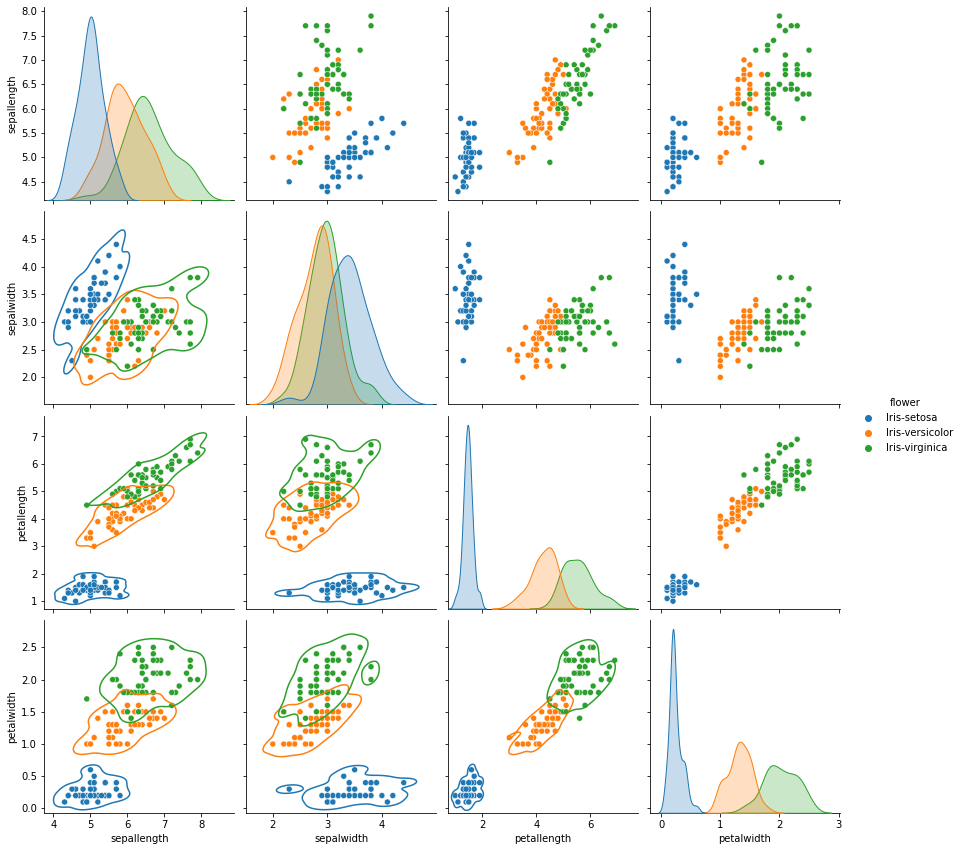

In [4]:
df = pandas.read_csv('iris.data')

# SCATTER PLOT
g = seaborn.pairplot(df, hue='flower', height=3, diag_kind='kde')
_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

## ROBUST COOKING

In [5]:
# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

# PREPROCESSING X AND Y
my_vars = list(df.columns[df.columns != class_col])
df_X = df[my_vars]
one_hot = OneHotEncoder(sparse=False)
df_Y_categorical = df[[class_col]]
Y_array_categorical = df_Y_categorical.to_numpy()
one_hot.fit(Y_array_categorical)
df_Y = pandas.DataFrame(one_hot.transform(Y_array_categorical))
df_Y.columns = one_hot.categories_

# PREPARE DATA
X = df_X.to_numpy()
Y = df_Y.to_numpy()

# NORMALIZE VARIABLES
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

# GET STRATIFIED FOLDS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_scaled, Y_array_categorical)

# TRAINING LOOP
n_classes = df_Y.columns.shape[0]
hidden_layers = 1

# PATTERN SEARCH
search_vector = numpy.identity(len(hidden_activations), dtype=int)
current_configurations = search_vector

still_searching = True
best_net_name = None
best_net = None
best_config = None
best_metric = 0.0
best_metric_val = 0.0
metric_lower_bound = 0.0
result_list = []

print('COOKING BEST NETWORK STARTED...\n')
while still_searching:
    for net_config in current_configurations:
        print('CONFIG: {}'.format(net_config))
        ix_fold = 1
        for train_index, test_index in sk_folds.split(X_scaled, Y_array_categorical):
            print('FOLD: {}/{}'.format(ix_fold, n_k_folds))

            # GET STRATIFIED DATA
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            for optimizer in my_optimizers.keys():

                # DECLARE NET
                inputs = keras.Input(shape=(len(my_vars), ))
                hidden_layer_list = []
                net_name = ''
                for ix_activation in numpy.arange(len(net_config)):
                    f_activation = hidden_activations[ix_activation]
                    n_neuron = net_config[ix_activation]
                    if n_neuron > 0:
                        temp_hidden_layer = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
                        hidden_layer_list.append(temp_hidden_layer)
                        net_name += '{}{}'.format(f_activation, n_neuron)
                if len(hidden_layer_list) > 1:
                    hidden = keras.layers.Concatenate(axis=1)(hidden_layer_list)
                else:
                    hidden = hidden_layer_list[0]
                outputs = keras.layers.Dense(n_classes, activation='sigmoid')(hidden)
                model_name = '{}_{}_F{}_WRAPPER'.format(net_name.upper(), optimizer.upper(), ix_fold)
                my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # COMPILE NET
                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                my_net.compile(optimizer=my_optimizers[optimizer], loss='mse', metrics=[my_metric])
                es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=metric_name, mode='max', patience=my_patience, min_delta=min_improvement)
                es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_metric_name, mode='max',
                                                                        patience=n_k_folds*my_patience, min_delta=min_improvement)

                # FIT WRAPPER
                with tensorflow.device('/gpu:0'):
                    history = my_net.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0], 
                                         epochs=10*my_patience, verbose=0, callbacks=[es_loss, es_metric, es_val_metric])

                # CALCULATE VARIABLE RELEVANCE
                Y_est = my_net.predict(X_scaled)
                relevance_dict = {}
                for feature in my_vars:
                    X_relevance = numpy.copy(X_scaled)
                    X_relevance[:, df_X.columns == feature] = 0.0
                    Y_est_relevance = my_net.predict(X_relevance)
                    Y_relevance = (Y_est - Y_est_relevance)**2
                    feature_relevance = Y_relevance.sum()/Y_relevance.shape[0]
                    relevance_dict[feature] = feature_relevance
                s_relevance = pandas.Series(relevance_dict)
                s_relevance_norm = s_relevance/s_relevance.max()
                s_relevance_norm = s_relevance_norm.sort_values(ascending=False).head(relevant_features)
                selected_features = list(s_relevance_norm.index.values)
                selected_relevance = list(100.0*s_relevance_norm.values)

                # FINAL NET
                inputs = keras.Input(shape=(len(selected_features), ))
                hidden_layer_list = []
                net_name = ''
                for ix_activation in numpy.arange(len(net_config)):
                    f_activation = hidden_activations[ix_activation]
                    n_neuron = net_config[ix_activation]
                    if n_neuron > 0:
                        temp_hidden_layer = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
                        hidden_layer_list.append(temp_hidden_layer)
                        net_name += '{}{}'.format(f_activation, n_neuron)
                if len(hidden_layer_list) > 1:
                    hidden = keras.layers.Concatenate(axis=1)(hidden_layer_list)
                else:
                    hidden = hidden_layer_list[0]
                outputs = keras.layers.Dense(n_classes, activation='sigmoid')(hidden)
                model_name = '{}_{}_F{}'.format(net_name.upper(), optimizer.upper(), ix_fold)
                my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # COMPILE NET
                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                my_net.compile(optimizer=my_optimizers[optimizer], loss='mse', metrics=[my_metric])
                es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=metric_name, mode='max', patience=my_patience, min_delta=min_improvement)
                es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_metric_name, mode='max',
                                                                        patience=n_k_folds*my_patience, min_delta=min_improvement)

                # FIT FINAL
                ix_relevant = df_X.columns.isin(selected_features)
                with tensorflow.device('/gpu:0'):
                    history = my_net.fit(X_train[:, ix_relevant], Y_train, validation_data=(X_test[:, ix_relevant], Y_test), batch_size=X_train.shape[0],
                                        epochs=10*my_patience, verbose=0, callbacks=[es_loss, es_metric, es_val_metric])

                # UNPACK TRAINING RESULTS
                model_loss = history.history['loss'][-1]
                model_val_loss = history.history['val_loss'][-1]
                metric_val = history.history[metric_name][-1]
                val_metric_val = history.history[val_metric_name][-1]
                n_epochs = len(history.history['val_loss'])

                # CHECK IF BEST NET
                best_net_txt = ''
                is_best = False
                if ((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement)):
                    best_net_name = model_name
                    best_optimizer = optimizer
                    best_config = net_config
                    best_features = selected_features
                    best_net = my_net
                    best_neurons = n_neuron
                    best_metric = metric_val
                    best_metric_val = val_metric_val
                    best_net_txt = '**Best NET!**'
                    is_best = True

                result_dict = {'model_name': model_name, 'optimizer': optimizer, 'net_config': net_config, 'neurons': net_config.sum(), 'fold': ix_fold, 'features': selected_features, 'relevance': selected_relevance, 'loss': model_loss,
                    'val_loss': model_val_loss, metric_name: metric_val, val_metric_name: val_metric_val, 'epochs': n_epochs, 'is_best': is_best, 'net': my_net}
                result_list.append(result_dict)
                if is_best:
                    print('{}_{} > epochs: {} loss: {:.2f} val_loss: {:.2f} {}: {:.0f}% {}: {:.0f}% {}'.format(model_name,'_'.join(selected_features), n_epochs, model_loss, model_val_loss, metric_name, 100.0*metric_val, val_metric_name, 100.0*val_metric_val, best_net_txt))

                # IF MAXIMIZED METRICS BREAK
                maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)
                if maximized_metrics:
                    break
            
            if maximized_metrics:
                break

            ix_fold += 1

        if maximized_metrics:
            break

    # TEST IF MORE NEURONS ARE NECESSARY
    dont_need_extra_neurons = False
    total_neurons = net_config.sum()

    if total_neurons > 1:
        
        # INCREASING NEURONS DIDNT ACHIEVE BEST NET
        if best_neurons < total_neurons:
            dont_need_extra_neurons = True
            print('NETs w {} neurons didnt improve {}!'.format(total_neurons, metric_name))
            break
    
    # CALCULATE CONFIG LOWER BOUND
    df_results = pandas.DataFrame(result_list)
    ix_config = numpy.array([numpy.linalg.norm(best_config - x) for x in df_results.net_config]) == 0.0
    lower_bound_est = df_results[(df_results.optimizer == best_optimizer) & ix_config][val_metric_name].min()

    # TEST IF LOWER BOUND IMPROVED
    lower_bound_didnt_improve = False
    if total_neurons > 1:
        neuron_gain = 0.0
        if lower_bound_est > metric_lower_bound:
            if metric_lower_bound > 0.0:
                neuron_gain = lower_bound_est/metric_lower_bound - 1.0
                if neuron_gain <= min_neuron_gain:
                    print('NETs w {} neurons didnt improve min {} {:.1f} neuron gain {:.1f} / min {:.1f}!'.format(total_neurons, val_metric_name, 100.0*lower_bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain))
                    lower_bound_didnt_improve = True
                    break
                else:
                    print('NETs Neuron Gain w/ {} neurons: {:.1f} >> {:.1f} = {:.2f}%'.format(total_neurons, 100.0*metric_lower_bound, 100.0*lower_bound_est ,100.0*neuron_gain))
            else:
                print('NET Neural Gain From 0.0 >> {:.1f}%'.format(100.0*lower_bound_est))
        else:
            print('No Lower Bound Gain on {} neurons for {}: {:.1f} >> {:.1f}'.format(total_neurons, best_optimizer, 100.0*metric_lower_bound, 100.0*lower_bound_est))
            lower_bound_didnt_improve = True
            break
    else:
        print('BEST CONFIG {} & min quality for {}: {:.1f}%'.format(best_config, best_optimizer.upper(), 100.0*lower_bound_est))
    
    metric_lower_bound = lower_bound_est

    # ALTER CONFIG FROM BEST CONFIG IF NEEDED
    if maximized_metrics or dont_need_extra_neurons or lower_bound_didnt_improve:
        still_searching = False
    else:
        current_configurations = best_config + search_vector

COOKING BEST NETWORK STARTED...

CONFIG: [1 0]
FOLD: 1/3
5/5 [==============================] - 0s 7ms/step
LINEAR1_ADAGRAD_F1_petallength_sepalwidth > epochs: 51 loss: 0.22 val_loss: 0.22 accuracy: 66% val_accuracy: 68% **Best NET!**
5/5 [==============================] - 0s 4ms/step
LINEAR1_RMSPROP_F1_sepallength_petalwidth > epochs: 314 loss: 0.09 val_loss: 0.08 accuracy: 92% val_accuracy: 96% **Best NET!**
5/5 [==============================] - 0s 5ms/step
FOLD: 2/3
5/5 [==============================] - 0s 6ms/step
FOLD: 3/3
5/5 [==============================] - 0s 4ms/step
CONFIG: [0 1]
FOLD: 1/3
5/5 [==============================] - 0s 5ms/step
FOLD: 2/3
5/5 [==============================] - 0s 5ms/step
FOLD: 3/3
5/5 [==============================] - 0s 5ms/step
BEST CONFIG [1 0] & min quality for RMSPROP: 66.0%
CONFIG: [2 0]
FOLD: 1/3
5/5 [==============================] - 0s 5ms/step
FOLD: 2/3
5/5 [==============================] - 0s 4ms/step
FOLD: 3/3
5/5 [==============

In [6]:
# ROLL BACK TO LESS NEURON IF DIDNT IMPROVE
if lower_bound_didnt_improve and rollback_on_no_lower_bound_gain:
    best_row = df_results[(df_results.neurons == n_neuron - 1) & df_results.is_best].tail(1)
    best_net_name = best_row['model_name'].values[0]
    best_optimizer = best_row['optimizer'].values[0]
    best_net = best_row['net'].values[0]
    best_config = best_row['net_config'].values[0]
    best_features = best_row['features'].values[0]
    best_neurons = best_row['neurons'].values[0]
    best_metric = best_row[metric_name].values[0]
    best_metric_val = best_row[val_metric_name].values[0]

In [7]:
# CLASS COLOR GRID & CLASS EVALUATION
grid_n_points = 100
little_delta = 0.1
jitter_factor = 0.1
rect_expansion = 1.1

# X0 W JITTER
X_plot = df_X[best_features].to_numpy()

x0_grid = numpy.linspace(0, rect_expansion*(X_plot[:, 0].max()), grid_n_points)
x0_jitter = jitter_factor*(x0_grid[1] - x0_grid[0])
x1_grid = numpy.linspace(0, rect_expansion*(X_plot[:, 1].max()), grid_n_points)
x1_jitter = jitter_factor*(x1_grid[1] - x1_grid[0])
X_g = numpy.array(list(itertools.product(x0_grid, x1_grid)))
X_g[:, 0] += x0_jitter*numpy.random.randn(X_g.shape[0])
X_g[:, 1] += x1_jitter*numpy.random.randn(X_g.shape[0])
X_g_scaled = StandardScaler().fit_transform(X_g)
Y_g = best_net.predict(X_g_scaled)
Y_g_class = numpy.array([df_Y.columns[x][0] for x in numpy.argmax(Y_g, axis=1)])

# CLASSIFY DATA
ix_best_features = df_X.columns.isin(best_features)
Y_est = best_net.predict(X_scaled[:, ix_best_features])
Y_class_est = numpy.array([df_Y.columns[x][0] for x in numpy.argmax(Y_est, axis=1)])
# t_error, t_statistic = best_net.evaluate(X_scaled[:, ix_best_features], Y, verbose=0)

ix_missclass = df_Y_categorical[class_col].to_numpy() != Y_class_est
missclass = X_plot[ix_missclass]
x_0_miss = missclass[:, 0]
x_1_miss = missclass[:, 1]

5/5 [==============================] - 0s 3ms/step


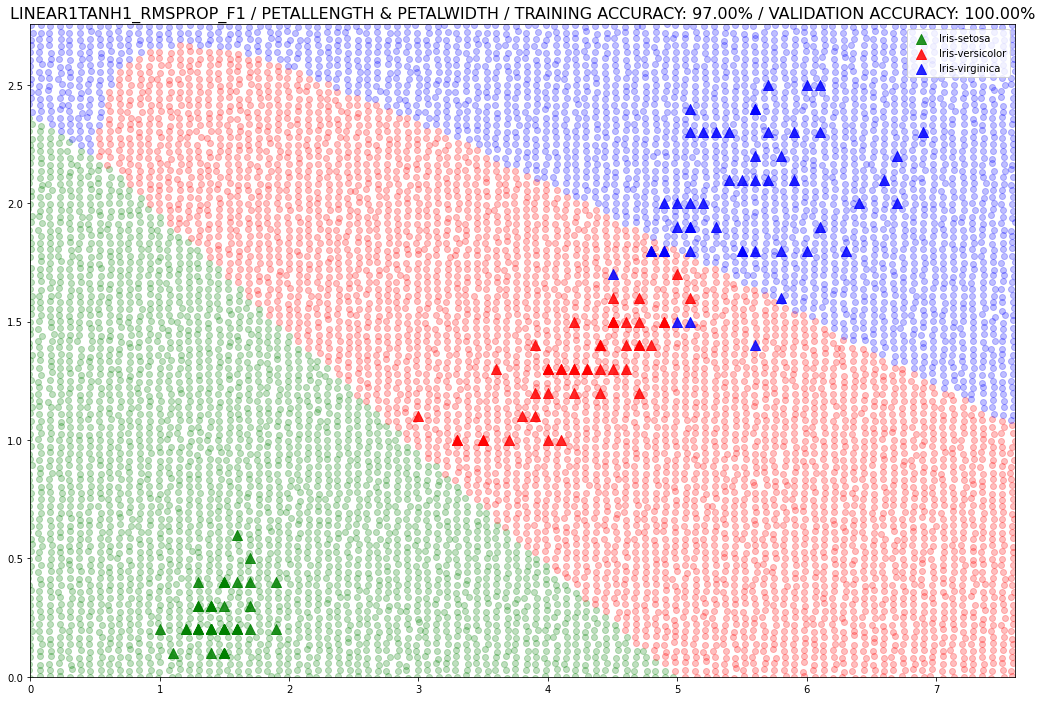

In [8]:
# CLASSIFICATION FIGURE
fig = pyplot.figure(figsize=(12/0.68, 12))
ax = fig.add_subplot(111)

color_list = ['green', 'red', 'blue', 'yellow']

# GIVE COLOURS TO CLASS
color_dict = {}
ix_color = 0
for yclass in df_Y.columns:
    color_dict[yclass[0]] = color_list[ix_color]
    ix_color += 1

# PLOT CLASS REGION
for yclass in df_Y.columns:
    ix_class_cloud = Y_g_class == yclass[0]
    x_0_cloud = X_g[ix_class_cloud, 0]
    x_1_cloud = X_g[ix_class_cloud, 1]
    _ = ax.scatter(x_0_cloud, x_1_cloud, marker='o', color=color_dict[yclass[0]], alpha=0.25)

for yclass in df_Y.columns:
    ix_class = Y_array_categorical.squeeze() == yclass[0]
    x_0 = X_plot[ix_class, 0]
    x_1 = X_plot[ix_class, 1]
    _ = ax.scatter(x_0, x_1, color=color_dict[yclass[0]], marker='^', alpha=0.85, s=100, label=yclass[0])
# _ = ax.scatter(x_0_miss, x_1_miss, color='black', marker='x', alpha=0.85, s=200)
_ = ax.legend()
_ = ax.set_xlim([0.0, X_g[:, 0].max()])
_ = ax.set_ylim([0.0, X_g[:, 1].max()])
_ = ax.set_title('{} / {} / training {}: {:.2f}% / validation {}: {:.2f}%'.format(best_net_name, ' & '.join(best_features), metric_name, 100.0*best_metric, metric_name,100.0*best_metric_val).upper(), size=16)

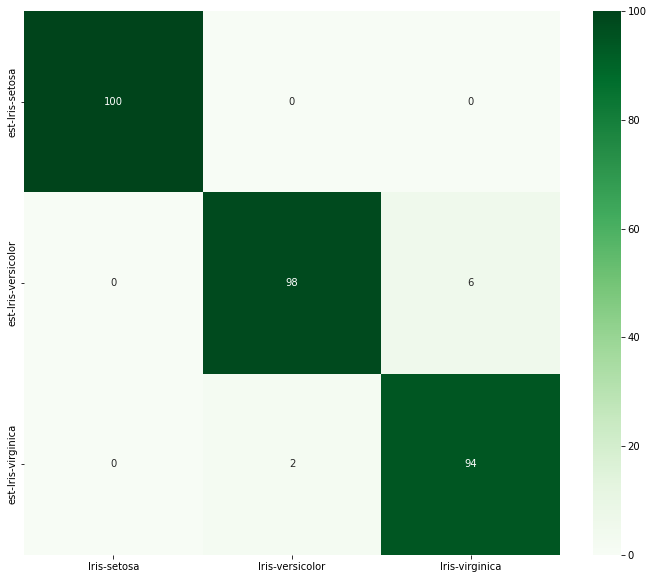

In [9]:
my_classes = [x[0] for x in df_Y.columns.values]
my_conf = confusion_matrix(df_Y_categorical[class_col].to_numpy(), Y_class_est, labels=my_classes)
# df_conf = pandas.DataFrame(my_conf, index=my_classes, columns=['est-{}'.format(x) for x in my_classes])
df_conf = pandas.DataFrame(100.0*my_conf/my_conf.sum(axis=0), index=['est-{}'.format(x) for x in my_classes], columns=my_classes)

fig, ax = pyplot.subplots(figsize=(12,10)) 
_ = seaborn.heatmap(df_conf, cmap="Greens", ax=ax, annot=True, fmt='.0f')